In [21]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [22]:
image_path = 'Picture1.jpg'
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

In [23]:
def resize_image(image):
    dimensions = (200, 200)
    resized_linear = cv2.resize(image, dimensions, interpolation=cv2.INTER_LINEAR)
    resized_nearest = cv2.resize(image, dimensions, interpolation=cv2.INTER_NEAREST)
    resized_polynomial = cv2.resize(image, dimensions, interpolation=cv2.INTER_CUBIC)
    return resized_linear, resized_nearest, resized_polynomial

In [24]:
def blur_image(image):
    box_blur = cv2.blur(image, (5, 5))
    gaussian_blur = cv2.GaussianBlur(image, (5, 5), 0)
    adaptive_blur = cv2.bilateralFilter(image, 9, 75, 75)
    return box_blur, gaussian_blur, adaptive_blur

In [25]:
resized_linear, resized_nearest, resized_polynomial = resize_image(image)

In [26]:
box_blur, gaussian_blur, adaptive_blur = blur_image(image)

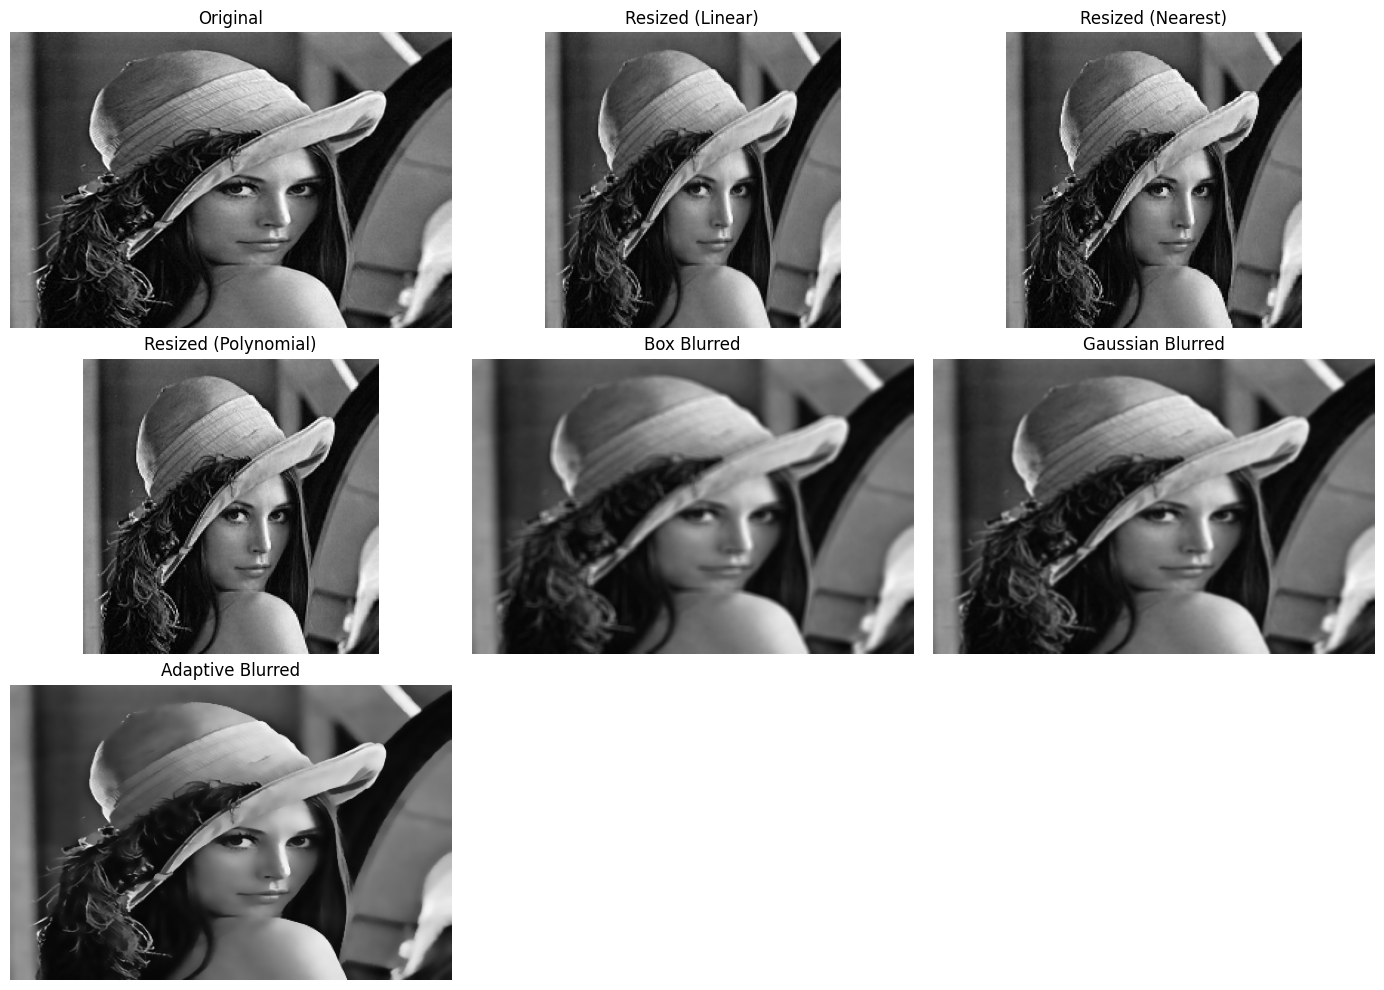

In [27]:
def plot_images(images, titles):
    plt.figure(figsize=(14, 10))
    for i, (img, title) in enumerate(zip(images, titles)):
        plt.subplot(3, 3, i + 1)
        plt.imshow(img)
        plt.title(title)
        plt.axis('off')
    plt.tight_layout()
    plt.show()

images = [image, resized_linear, resized_nearest, resized_polynomial, box_blur, gaussian_blur, adaptive_blur]
titles = [
    'Original', 'Resized (Linear)', 'Resized (Nearest)', 'Resized (Polynomial)',
    'Box Blurred', 'Gaussian Blurred', 'Adaptive Blurred'
]

plot_images(images, titles)

In [28]:
from sklearn.model_selection import train_test_split, KFold, cross_val_score, cross_validate
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
    roc_auc_score,
    roc_curve
)
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import mnist

In [29]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()


In [30]:
X = np.concatenate((X_train, X_test), axis=0)
y = np.concatenate((y_train, y_test), axis=0)

In [31]:
X = X.reshape(X.shape[0], -1).astype("float32") / 255.0


In [32]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [33]:
models = {
    "Naive Bayes": GaussianNB(),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42)
}

In [34]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)


In [35]:
def evaluate_model(model, X_train, X_test, y_train, y_test):
    # Train the model
    model.fit(X_train, y_train)
    # Predict on test set
    y_pred = model.predict(X_test)
    # Binarize labels for ROC and AUC
    y_test_bin = label_binarize(y_test, classes=np.unique(y_test))
    y_pred_bin = label_binarize(y_pred, classes=np.unique(y_test))
    # Compute metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average="weighted")
    recall = recall_score(y_test, y_pred, average="weighted")
    f1 = f1_score(y_test, y_pred, average="weighted")
    cm = confusion_matrix(y_test, y_pred)
    roc_auc = roc_auc_score(y_test_bin, y_pred_bin, multi_class="ovr")
    # Return metrics
    return accuracy, precision, recall, f1, cm, roc_auc

In [36]:
results = {}


In [37]:
for model_name, model in models.items():
    print(f"Evaluating {model_name}...")
    accuracy, precision, recall, f1, cm, roc_auc = evaluate_model(model, X_train, X_test, y_train, y_test)
    results[model_name] = {
        "Accuracy": accuracy,
        "Precision": precision,
        "Recall": recall,
        "F1-Score": f1,
        "Confusion Matrix": cm,
        "ROC AUC": roc_auc,
    }
    # Cross-validation
    cv_results = cross_validate(model, X_train, y_train, cv=kf, scoring=["accuracy", "precision_weighted", "recall_weighted", "f1_weighted"])
    print(f"{model_name} - Cross-validation Results:")
    print(f"Mean Accuracy: {cv_results['test_accuracy'].mean():.4f}")
    print(f"Mean Precision: {cv_results['test_precision_weighted'].mean():.4f}")
    print(f"Mean Recall: {cv_results['test_recall_weighted'].mean():.4f}")
    print(f"Mean F1-Score: {cv_results['test_f1_weighted'].mean():.4f}\n")

Evaluating Naive Bayes...
Naive Bayes - Cross-validation Results:
Mean Accuracy: 0.5508
Mean Precision: 0.6698
Mean Recall: 0.5508
Mean F1-Score: 0.5042

Evaluating Random Forest...
Random Forest - Cross-validation Results:
Mean Accuracy: 0.9672
Mean Precision: 0.9672
Mean Recall: 0.9672
Mean F1-Score: 0.9672



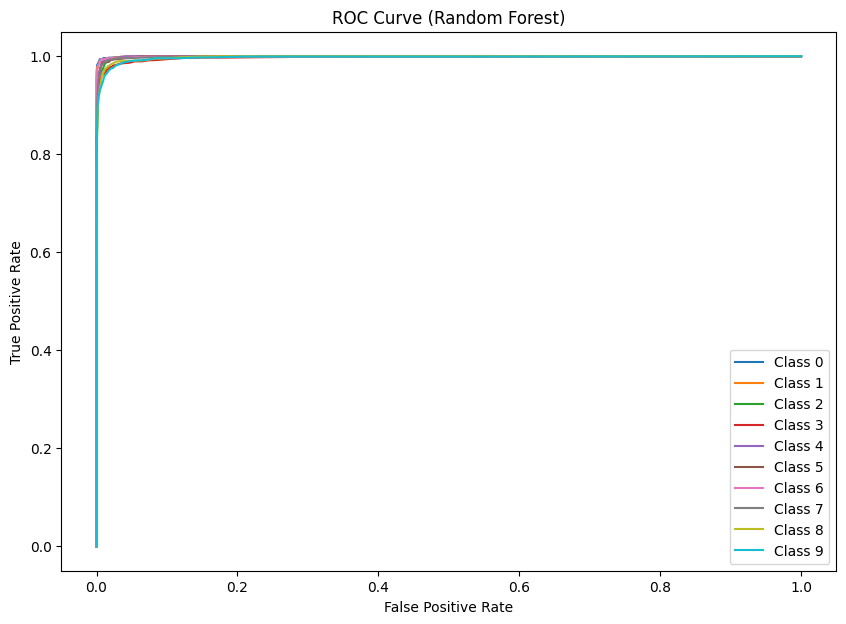

In [38]:
model_rf = RandomForestClassifier(n_estimators=100, random_state=42)
model_rf.fit(X_train, y_train)
y_pred_prob = model_rf.predict_proba(X_test)
fpr = {}
tpr = {}
for i in range(10):
    fpr[i], tpr[i], _ = roc_curve(label_binarize(y_test, classes=range(10))[:, i], y_pred_prob[:, i])

plt.figure(figsize=(10, 7))
for i in range(10):
    plt.plot(fpr[i], tpr[i], label=f"Class {i}")
plt.title("ROC Curve (Random Forest)")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.show()